In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier


import random
random.seed(42)
np.random.seed(42)

In [2]:
X = pd.read_csv("data/x_train.txt", header=None, sep=" ")
y = pd.read_csv("data/y_train.txt", header=None)[0]

In [3]:
best_features = [105, 101, 100, 102, 8, 104, 103, 5, 3, 4, 2, 6]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def custom_cost_function(features, y_test, y_pred):
    posit_count_true = np.sum(y==1)
    precision = precision_score(y_test, y_pred)
    numb_of_features = len(features)
    return 10*posit_count_true*precision - 200*numb_of_features

In [11]:
def get_classfier_param_grid(code, best_params={}):
    if code == 'rf':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("rf", RandomForestClassifier(n_estimators=50, random_state=0, **best_params)),
            ]), {
            "rf__max_depth": [2, 4, 6],
            "rf__min_samples_split": [2, 4, 6],
            "rf__min_samples_leaf": [2, 5, 10,],
            "rf__max_features": ["sqrt", "log2"],
            },

    elif code == 'mlp':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("mlp", MLPClassifier(early_stopping=True, tol=0.005, n_iter_no_change=8, **best_params)),
            ]), {
        'mlp__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'mlp__activation': ['tanh', 'relu'],
        'mlp__solver': ['sgd', 'adam'],
        'mlp__alpha': [0.0001, 0.05],
        'mlp__learning_rate': ['constant','adaptive']}
    
    
    elif code == 'svm':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("svm", SVC(random_state=0, **best_params)),
            ]),{
            "svm__C": [0.1, 1, 10],
            "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
            "svm__gamma": ["scale", "auto"],
        },


    elif code == 'gp':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("gpc", GaussianProcessClassifier(kernel=RBF(1.0))),
            ]
        ), {}
    

    elif code == 'qda':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("qda", QuadraticDiscriminantAnalysis()),
            ]
        ), {}
    

    elif code == 'xgb':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("xgb", XGBClassifier(random_state=0, use_label_encoder=False, **best_params)),
            ]),{
            "xgb__n_estimators": [100, 200, 300],
            "xgb__max_depth": [3, 4, 5],
            "xgb__learning_rate": [0.01, 0.1, 0.3],
            "xgb__subsample": [0.8, 1.0],
        }
    
    
    elif code == 'nb':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("nb", GaussianNB())
            ]), {
            "nb__var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    
    elif code == 'knn':
        return Pipeline(
            [
                ("scaler", StandardScaler()),
                ("knn", KNeighborsClassifier())
            ]), {
            "knn__n_neighbors": [3, 5, 7, 9],
            "knn__weights": ["uniform", "distance"],
            "knn__p": [1, 2]
        }
    
    elif code == 'ada':
        return Pipeline([
                ("scaler", StandardScaler()),
                ("ada", AdaBoostClassifier())
            ]), {
            "ada__n_estimators": [50, 100, 200],
            "ada__learning_rate": [0.1, 0.5, 1.0],
            "ada__algorithm": ["SAMME", "SAMME.R"]
        }
    elif code == 'lr':
        return Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression())
            ]), {
            "lr__C": [0.001, 0.01, 0.1, 1.0],
            "lr__penalty": ["l1", "l2"],
            "lr__solver": ["liblinear", "saga"]
        }

    elif code == 'ert':
        return Pipeline([
                ("scaler", StandardScaler()),
                ("ert", ExtraTreesClassifier(n_estimators=50))
            ]), {
            "ert__max_depth": [None, 10, 20],
            "ert__min_samples_split": [2, 5, 10],
            "ert__min_samples_leaf": [1, 2, 4],
            "ert__max_features": ["sqrt", "log2"]
        }
    else:
        raise Exception('Code not recognizible')
    


In [35]:
def fit_grid_search(X, y, clf_code):
    clf, param_grid = get_classfier_param_grid(clf_code)
    return GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
        n_jobs=-1,
    ).fit(X=X, y=y)

In [36]:
model_codes = ['rf', 'mlp', 'svm', 'gp', 'qda', 'xgb', 'nb', 'knn', 'ada', 'lr', 'ert']

In [37]:
column_names = ['Model', 'hyperparameters', 'Features', 'Accuracy', 'Precision', 'Recall', 'Profit']
model_library = pd.DataFrame(columns=column_names)

In [21]:
def rename_hyperparameters(params, code):
    new_params = {}
    for key, val in params.items():
        new_key = key.replace(f'{code}__', '') 
        new_params[new_key] = val
    return new_params

In [20]:
rename_hyperparameters(model_library.loc[0].Model, model_library.loc[0].hyperparameters)

NameError: name 'rename_hyperparameters' is not defined

In [18]:
list(np.random.choice(len(model_codes), 4, replace=False))

[1, 5, 4, 8]

In [38]:
umb_of_feat = np.random.randint(2, 8)
features_inds = np.random.choice(len(best_features), numb_of_feat, replace=False)
features = [best_features[i] for i in features_inds]

In [ ]:
# for i in range(100):
#     print(i)
#     numb_of_feat = np.random.randint(2, 8)
#     features_inds = np.random.choice(len(best_features), numb_of_feat, replace=False)
#     features = [best_features[i] for i in features_inds]   

#     model_indeces = list(np.random.choice(len(model_codes), 4, replace=False))
#     for ind in model_indeces:
#        code = model_codes[ind]
#        print(f"Features: {features}, Model: {code}")
#        clf = fit_grid_search(X_train[features], y_train, code)
#        y_pred = clf.predict(X_test[features])
#        row = [code, rename_hyperparameters(clf.best_params_, code), features,
#               accuracy_score(y_test, y_pred),
#               precision_score(y_test, y_pred),
#               recall_score(y_test, y_pred),
#               custom_cost_function(features, y_test, y_pred)]
#        model_library.loc[len(model_library)] = row


In [103]:
model_library.to_csv('model_library.csv', index=False)

In [105]:
cos

,Model,hyperparameters,Features,Accuracy,Precision,Recall,Profit
0,qda,{},"[102, 4, 3, 101]",0.607,0.633411,0.537402,15009.930394
1,mlp,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...","[102, 4, 3, 101]",0.612,0.627119,0.582677,14852.881356
2,svm,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}","[102, 4, 3, 101]",0.617,0.645012,0.547244,15299.489559
3,nb,{'var_smoothing': 1e-09},"[102, 4, 3, 101]",0.607,0.644836,0.503937,15295.113350
4,svm,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}","[5, 4, 3]",0.588,0.607143,0.535433,14554.285714
...,...,...,...,...,...,...,...
395,lr,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}","[2, 8, 3, 100, 105, 5, 101]",0.516,0.531414,0.399606,11864.083770
396,svm,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}","[4, 103, 2, 104, 100]",0.650,0.659919,0.641732,15471.578947
397,gp,{},"[4, 103, 2, 104, 100]",0.665,0.679089,0.645669,15950.062112
398,knn,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}","[4, 103, 2, 104, 100]",0.599,0.614561,0.564961,14339.443255


In [95]:
model_library.sort_values('Profit', ascending=False).head(20)

,Model,hyperparameters,Features,Accuracy,Precision,Recall,Profit
102,qda,{},"[104, 4, 102, 2, 100, 103, 101]",0.722,0.745726,0.687008,17213.333333
51,nb,{'var_smoothing': 1e-09},"[8, 101, 100, 105]",0.658,0.706468,0.559055,16833.432836
114,qda,{},"[4, 2, 6, 102, 101, 5, 100]",0.697,0.729306,0.641732,16803.489933
214,qda,{},"[105, 2, 100, 6, 8, 3, 104]",0.686,0.728774,0.608268,16790.188679
50,mlp,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[8, 101, 100, 105]",0.673,0.702461,0.618110,16733.422819
389,qda,{},"[2, 100, 105, 8, 5, 103, 3]",0.690,0.725000,0.627953,16696.000000
149,gp,{},"[103, 100, 101, 2, 105]",0.692,0.707469,0.671260,16658.423237
373,rf,"{'max_depth': 4, 'max_features': 'sqrt', 'min_...","[105, 104]",0.618,0.682081,0.464567,16624.739884
88,nb,{'var_smoothing': 1e-09},"[105, 102, 100]",0.650,0.688995,0.566929,16597.320574
307,qda,{},"[8, 101, 100, 102, 4, 6]",0.677,0.711670,0.612205,16563.295195


Text(0.5, 1.0, 'Number of model occurances among top 100 classifiers by Profit')

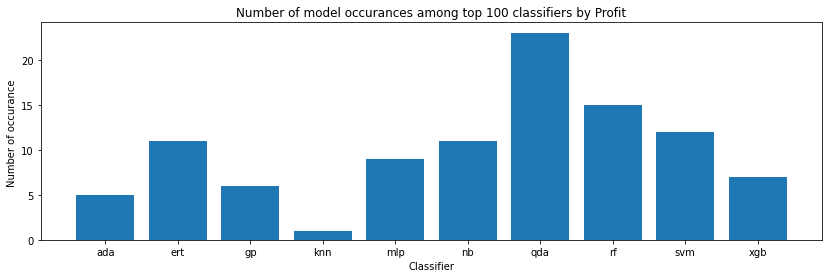

In [96]:
model, counts = np.unique(model_library.sort_values('Profit', ascending=False).head(100).Model, return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(model, counts)
plt.xlabel("Classifier")
plt.ylabel("Number of occurance ")
plt.title("Number of model occurances among top 100 classifiers by Profit")

Text(0.5, 1.0, 'Number of model occurances among top 100 classifiers by Profit')

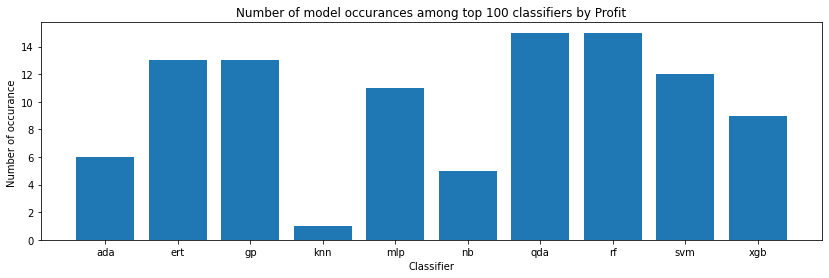

In [97]:
model, counts = np.unique(model_library.sort_values('Accuracy', ascending=False).head(100).Model, return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(model, counts)
plt.xlabel("Classifier")
plt.ylabel("Number of occurance ")
plt.title("Number of model occurances among top 100 classifiers by Profit")

Text(0.5, 1.0, 'Number of model occurances among top 100 classifiers by Profit')

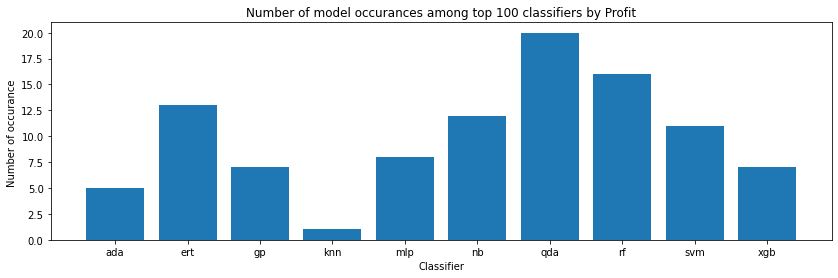

In [98]:
model, counts = np.unique(model_library.sort_values('Precision', ascending=False).head(100).Model, return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(model, counts)
plt.xlabel("Classifier")
plt.ylabel("Number of occurance ")
plt.title("Number of model occurances among top 100 classifiers by Profit")

Text(0.5, 1.0, 'Number of feature occurances among top 100 classifiers by Profit')

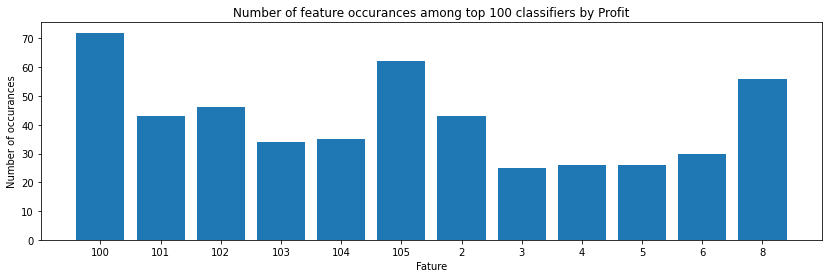

In [99]:
occurances = []
for feat_list in model_library.sort_values('Profit', ascending=False).head(100).Features:
    for feat in feat_list:
        occurances.append(feat)
feature, counts = np.unique([str(x) for x in occurances], return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(feature, counts)
plt.xlabel("Fature")
plt.ylabel("Number of occurances")
plt.title("Number of feature occurances among top 100 classifiers by Profit")

Text(0.5, 1.0, 'Number of features in models distribution among top 100 classifiers by Profit')

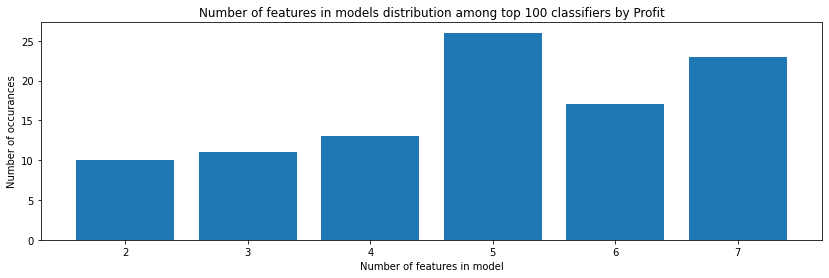

In [100]:
features_number = []
for feat_list in model_library.sort_values('Profit', ascending=False).head(100).Features:
    features_number.append(len(feat_list))
feature_num, counts = np.unique(features_number, return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(feature_num, counts)
plt.xlabel("Number of features in model")
plt.ylabel("Number of occurances")
plt.title("Number of features in models distribution among top 100 classifiers by Profit")

Text(0.5, 1.0, 'Number of features in models distribution among top 50 classifiers by Profit')

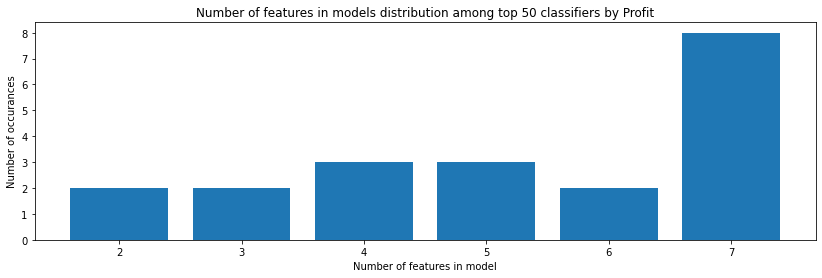

In [101]:
features_number = []
for feat_list in model_library.sort_values('Profit', ascending=False).head(20).Features:
    features_number.append(len(feat_list))
feature_num, counts = np.unique(features_number, return_counts=True)
plt.figure(figsize=(14, 4))
plt.bar(feature_num, counts)
plt.xlabel("Number of features in model")
plt.ylabel("Number of occurances")
plt.title("Number of features in models distribution among top 50 classifiers by Profit")

In [73]:
def recreate_clf(X, y, model_library, index):
    code, params, features = model_library.loc[index][['Model', 'hyperparameters', 'Features']]
    model, _ = get_classfier_param_grid(code, params)
    return model.fit(X[features], y)

In [74]:
recreate_clf(X_train, y_train, model_library, 23)

c:\Users\Ja\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [70]:
a, b = model_library.loc[0][['Features', 'Accuracy']]

In [72]:
b

0.572

In [64]:
model, _ = get_classfier_param_grid(model_library.loc[23].Model, model_library.loc[23].hyperparameters)

c:\Users\Ja\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [65]:
model.fit(X_train[model_library.loc[23].Features], y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [66]:
accuracy_score(model.predict(X_test[model_library.loc[23].Features]), y_test)

0.563

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Utwórz instancję estymatora RandomForestClassifier
estymator = RandomForestClassifier()

# Sprawdź dostępne parametry estymatora
dostepne_parametry = estymator.get_params().keys()

In [53]:
dostepne_parametry

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])